# mount drive

In [3]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [4]:
# import packages
import datetime
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [5]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")

In [6]:
data = pd.concat([train, test])
data["time"] = pd.to_datetime(data["time"])

In [7]:
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["weekday"] = data["time"].dt.weekday
data["isAM"] = (data.hour < 12).astype("int")
data["isweekend"] = (data.weekday >= 5).astype("int")

In [8]:
ld_col = ["x", "y", "direction"]

weekday_mean = data.iloc[:len(train)].groupby(ld_col + ["weekday"]).congestion.mean()
hour_mean = data.iloc[:len(train)].groupby(ld_col + ["hour"]).congestion.mean()

weekday_mean.colmuns = ["weekday_mean"]
hour_mean.colmuns = ["hour_mean"]

data = data.merge(weekday_mean, how="left", left_on=ld_col+["weekday"], right_index=True, suffixes=("", "_weekday_mean"))
data = data.merge(hour_mean, how="left", left_on=ld_col+["hour"], right_index=True, suffixes=("", "_hour_mean"))
data.head()

,time,x,y,direction,congestion,hour,minute,weekday,isAM,isweekend,congestion_weekday_mean,congestion_hour_mean
row_id,,,,,,,,,,,,
0,1991-04-01,0,0,EB,70.0,0,0,0,1,0,48.381551,40.708561
1,1991-04-01,0,0,NB,49.0,0,0,0,1,0,39.502621,38.258652
2,1991-04-01,0,0,SB,24.0,0,0,0,1,0,50.679245,42.615665
3,1991-04-01,0,1,EB,18.0,0,0,0,1,0,27.278302,23.601093
4,1991-04-01,0,1,NB,60.0,0,0,0,1,0,69.612159,67.551913


In [9]:
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

In [10]:
xs = train.x.unique().tolist()
ys = train.y.unique().tolist()
dirs = train.direction.unique().tolist()

feature_col = ["hour", "minute", "weekday", "isAM", "isweekend", "congestion_weekday_mean", "congestion_hour_mean"]

params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

oof_train = np.zeros((len(train), ))
oof_idx = []
all_models = {}
all_y_preds = {}

for x in xs:
    for y in ys:
        for dir in dirs:
            loc_dir = (x, y, dir)
            print("======== loop: {} ========".format(loc_dir))

            locdir_X_train = train[(train.x == x) & (train.y == y) & (train.direction == dir)][feature_col]
            locdir_y_train = train[(train.x == x) & (train.y == y) & (train.direction == dir)]["congestion"]
            locdir_X_test = test[(test.x == x) & (test.y == y) & (test.direction == dir)][feature_col]

            # loc & dir の組み合わせが存在しないときは処理しない
            if locdir_X_train.shape[0] == 0:
                print("{} is nothing".format(loc_dir))
                continue

            cv = TimeSeriesSplit(n_splits=5)

            y_preds = []
            models = []

            for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(locdir_X_train)):
                print(f"======== fold: {fold_idx} ========")
                X_tr, X_val = locdir_X_train.iloc[tr_idx], locdir_X_train.iloc[val_idx]
                y_tr, y_val = locdir_y_train.iloc[tr_idx], locdir_y_train.iloc[val_idx]
                
                lgb_train = lgb.Dataset(X_tr, y_tr)
                lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
                
                model = lgb.train(params, lgb_train,
                                valid_sets=[lgb_train, lgb_eval],
                                verbose_eval=10,
                                num_boost_round=1000,
                                early_stopping_rounds=10)
                
                oof_train[X_val.index] = \
                    model.predict(X_val, num_iteration=model.best_iteration)

                oof_idx += X_val.index.tolist()

                y_pred = model.predict(locdir_X_test, num_iteration=model.best_iteration)

                y_preds.append(y_pred)
                models.append(model)
            
            all_y_preds[loc_dir] = y_preds
            all_models[loc_dir] = models

======== loop: (0, 0, 'EB') ========
======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 8.3173	valid_1's l1: 9.76613
[20]	training's l1: 7.93986	valid_1's l1: 9.74217
Early stopping, best iteration is:
[16]	training's l1: 8.06932	valid_1's l1: 9.73462
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.01351	valid_1's l1: 9.8278
[20]	training's l1: 8.74597	valid_1's l1: 9.62383
[30]	training's l1: 8.58955	valid_1's l1: 9.52621
[40]	training's l1: 8.4766	valid_1's l1: 9.48188
[50]	training's l1: 8.40155	valid_1's l1: 9.46469
[60]	training's l1: 8.3439	valid_1's l1: 9.46032
[70]	training's l1: 8.30911	valid_1's l1: 9.46044
Early stopping, best iteration is:
[63]	training's l1: 8.33401	valid_1's l1: 9.45645
======== fold: 2 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.23507	valid_1's l1: 9.47297
[20]	training's l1: 8.96654	valid

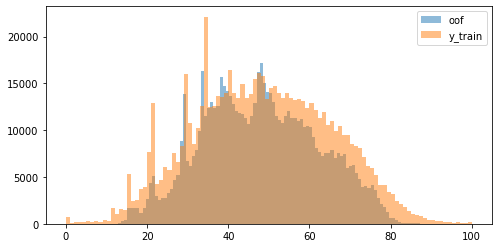

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[oof_idx], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[oof_idx].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()

In [12]:
scores = {}

for ld, ms in all_models.items():
    scores[ld] = ms[-1].best_score["valid_1"]["l1"]

score = sum(scores.values()) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
{(0, 0, 'EB'): 9.703977942746336, (0, 0, 'NB'): 7.856824087828496, (0, 0, 'SB'): 9.935173181334548, (0, 1, 'EB'): 6.186913308395489, (0, 1, 'NB'): 5.220399768225534, (0, 1, 'SB'): 5.390402883160067, (0, 1, 'WB'): 9.181390453823369, (0, 2, 'EB'): 4.808354853031286, (0, 2, 'NB'): 4.873039857839561, (0, 2, 'SB'): 6.584012096008962, (0, 2, 'WB'): 3.5642633539473434, (0, 3, 'EB'): 6.3269301800474675, (0, 3, 'NB'): 4.372743298321401, (0, 3, 'SB'): 6.649929349850488, (0, 3, 'WB'): 6.399637745092565, (0, 3, 'NE'): 7.099547226464502, (0, 3, 'SW'): 6.7001852830038535, (1, 0, 'EB'): 7.593886651287666, (1, 0, 'NB'): 8.764318539254631, (1, 0, 'SB'): 8.005055556002658, (1, 0, 'WB'): 4.7120982542790975, (1, 0, 'NE'): 9.036559581321077, (1, 0, 'SW'): 9.619804192974026, (1, 1, 'EB'): 10.097257023581685, (1, 1, 'NB'): 9.2108431842196, (1, 1, 'SB'): 7.178075991241398, (1, 1, 'WB'): 8.202340499543103, (1, 2, 'EB'): 5.949062818379864, (1, 2, 'NB'): 7.099647211547881, (1, 2, 'SB'): 6.20464

In [13]:
with open("../output/all_y_preds_009.pickle", "wb") as f:
    pickle.dump(all_y_preds, f)

with open("../output/all_models_009.pickle", "wb") as f:
    pickle.dump(all_models, f)

with open("../output/oof_train_009.pickle", "wb") as f:
    pickle.dump(oof_train, f)

with open("../output/oof_idx_009.pickle", "wb") as f:
    pickle.dump(oof_idx, f)

In [14]:
sub_pred = test.copy()[["x", "y", "direction", "congestion"]]

In [15]:
for (x, y, dir), y_preds in all_y_preds.items():
    sub_pred.loc[((test.x == x) & (test.y == y) & (test.direction == dir)), ["congestion"]] = y_preds[-1]

In [16]:
submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = sub_pred.congestion.to_numpy()
submission.to_csv("../submit/submission_009.csv", index=False)

===========(0, 0, 'EB')===========


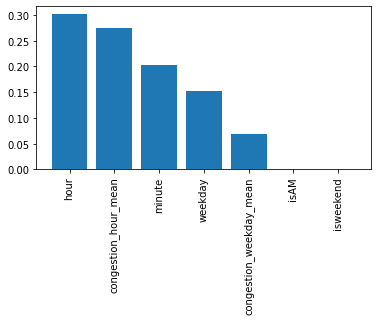

===========(0, 0, 'NB')===========


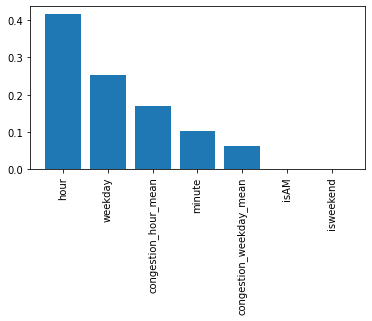

===========(0, 0, 'SB')===========


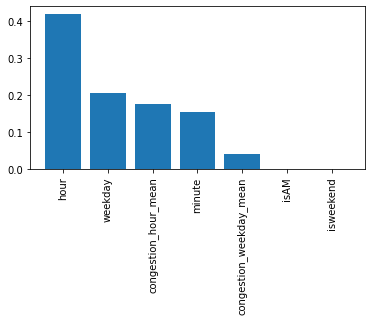

===========(0, 1, 'EB')===========


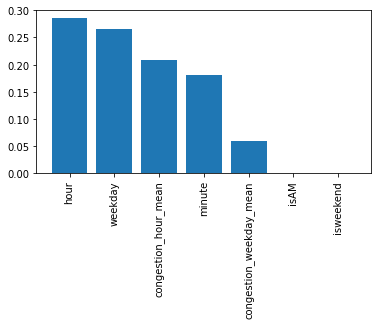

===========(0, 1, 'NB')===========


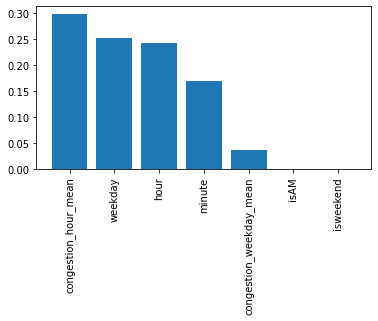

===========(0, 1, 'SB')===========


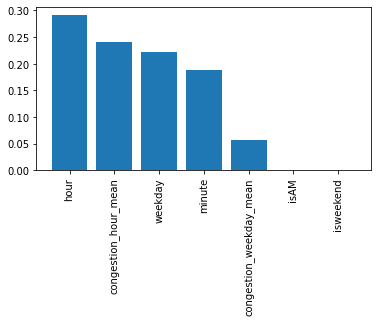

===========(0, 1, 'WB')===========


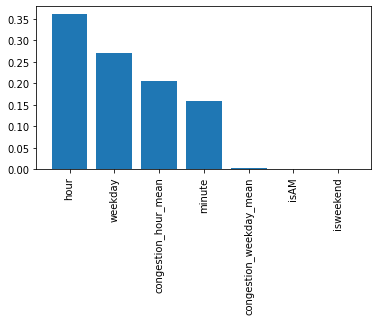

===========(0, 2, 'EB')===========


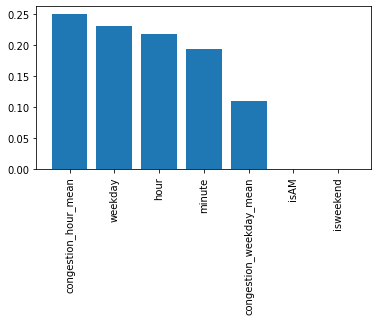

===========(0, 2, 'NB')===========


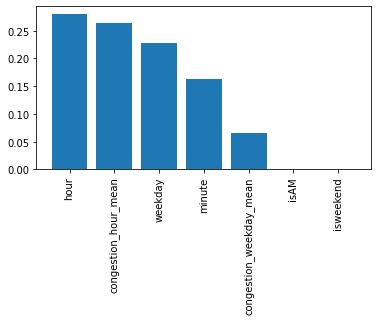

===========(0, 2, 'SB')===========


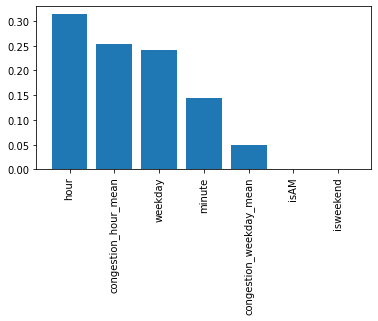

===========(0, 2, 'WB')===========


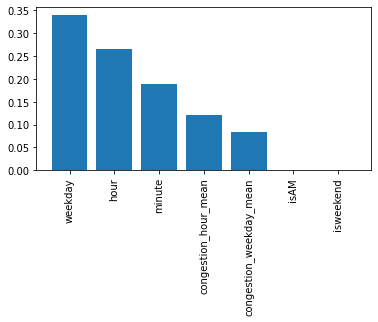

===========(0, 3, 'EB')===========


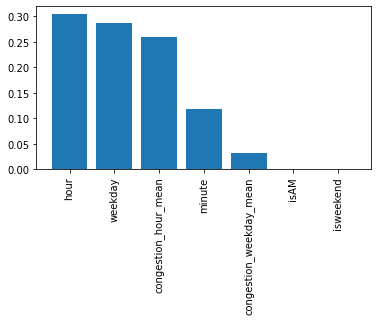

===========(0, 3, 'NB')===========


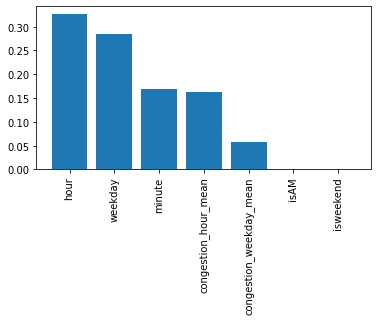

===========(0, 3, 'SB')===========


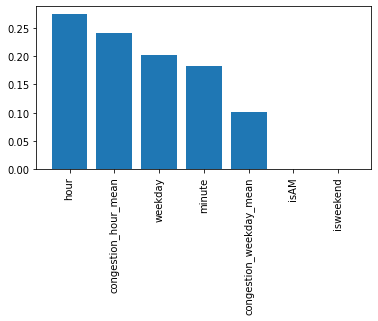

===========(0, 3, 'WB')===========


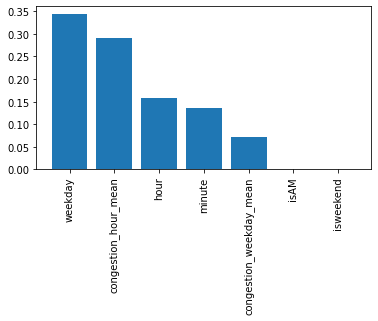

===========(0, 3, 'NE')===========


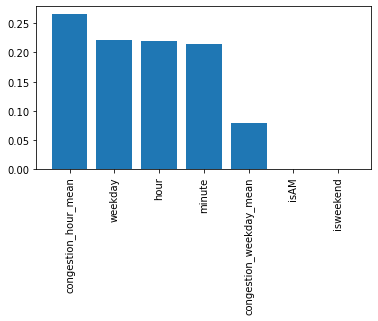

===========(0, 3, 'SW')===========


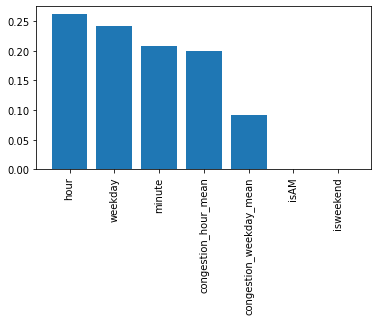

===========(1, 0, 'EB')===========


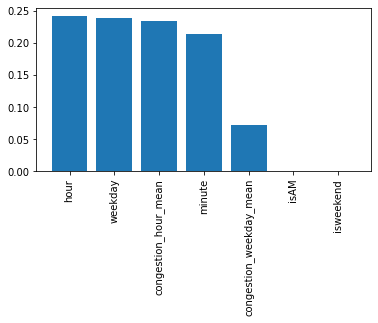

===========(1, 0, 'NB')===========


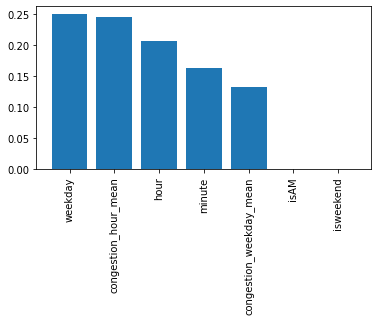

===========(1, 0, 'SB')===========


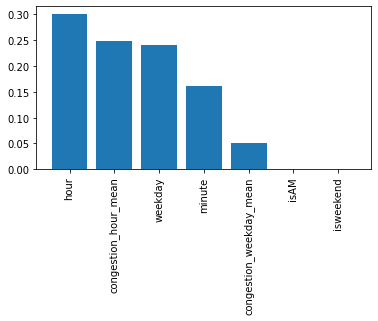

===========(1, 0, 'WB')===========


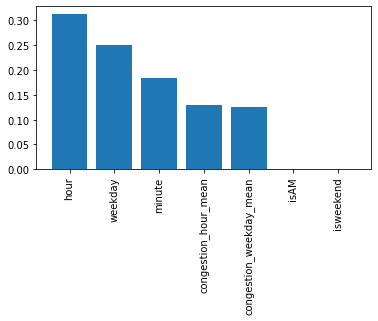

===========(1, 0, 'NE')===========


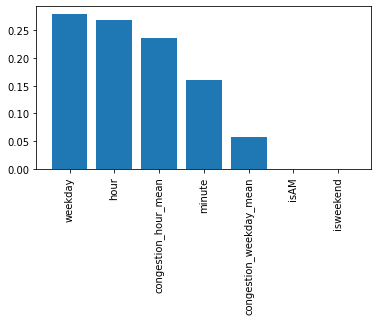

===========(1, 0, 'SW')===========


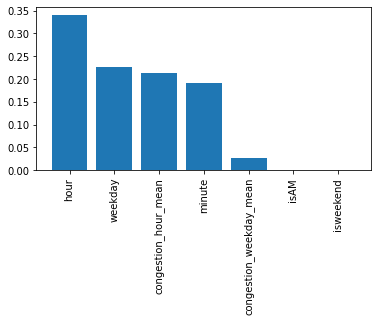

===========(1, 1, 'EB')===========


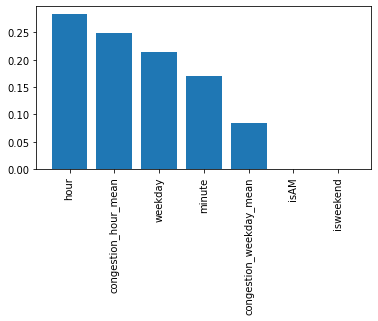

===========(1, 1, 'NB')===========


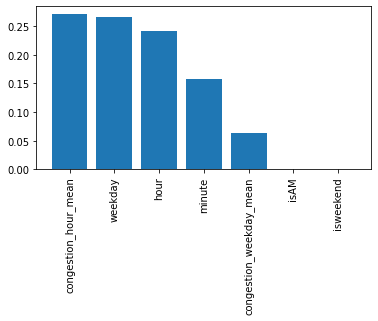

===========(1, 1, 'SB')===========


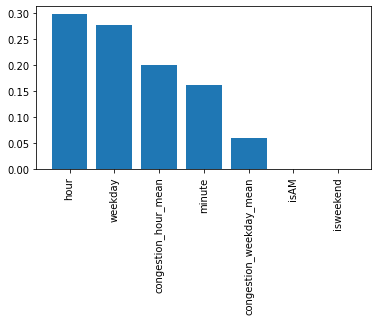

===========(1, 1, 'WB')===========


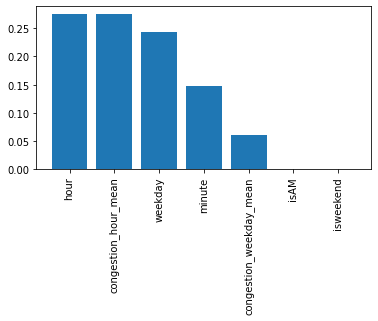

===========(1, 2, 'EB')===========


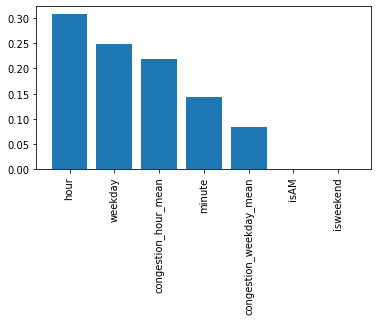

===========(1, 2, 'NB')===========


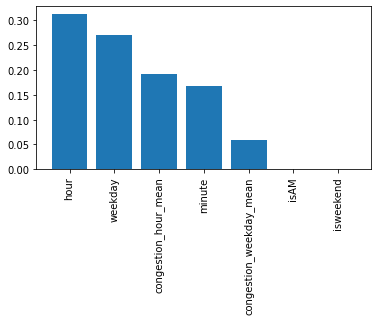

===========(1, 2, 'SB')===========


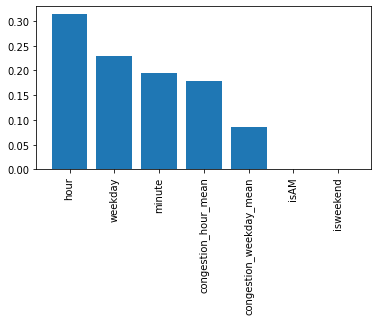

===========(1, 2, 'WB')===========


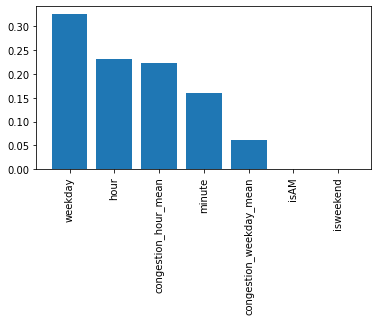

===========(1, 2, 'NE')===========


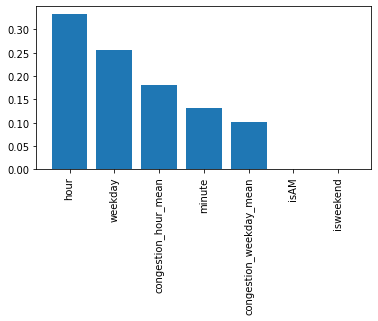

===========(1, 2, 'SW')===========


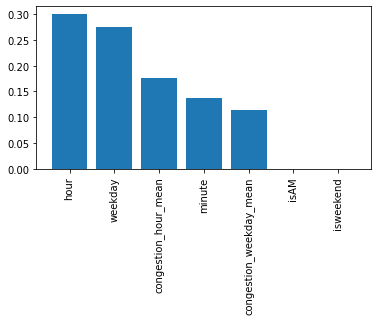

===========(1, 3, 'EB')===========


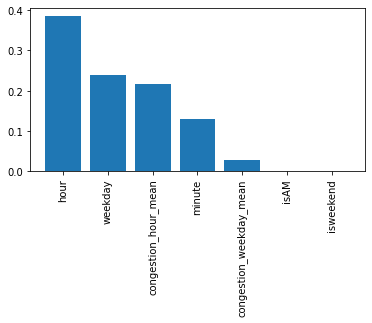

===========(1, 3, 'NB')===========


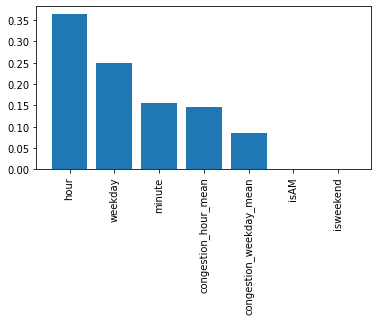

===========(1, 3, 'SB')===========


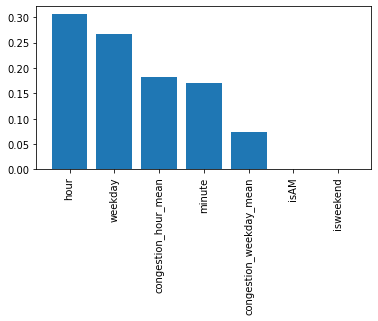

===========(1, 3, 'WB')===========


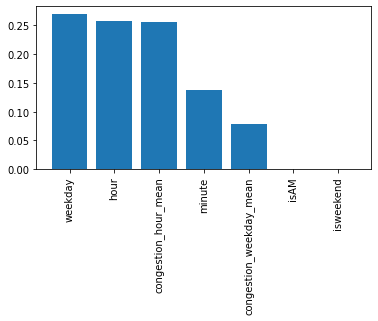

===========(1, 3, 'NE')===========


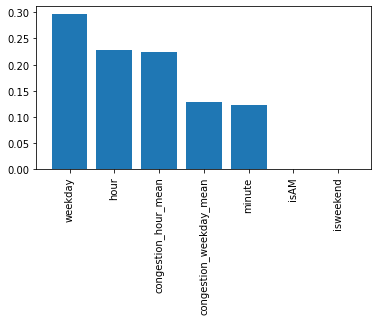

===========(1, 3, 'SW')===========


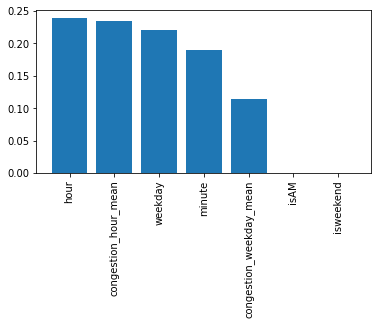

===========(2, 0, 'EB')===========


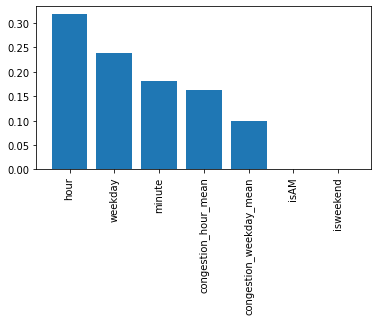

===========(2, 0, 'NB')===========


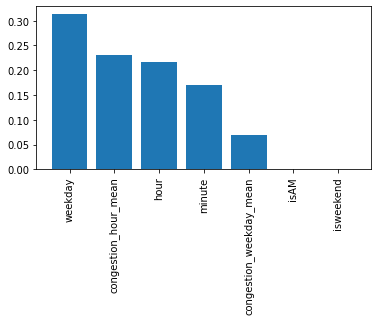

===========(2, 0, 'SB')===========


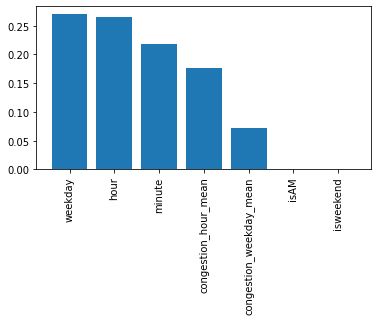

===========(2, 0, 'WB')===========


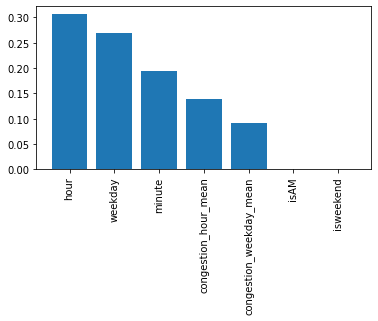

===========(2, 1, 'EB')===========


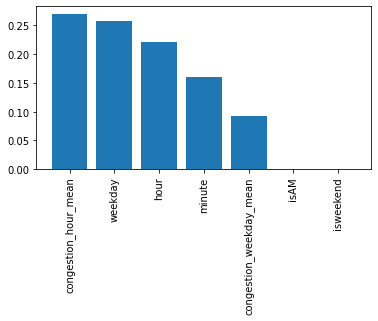

===========(2, 1, 'NB')===========


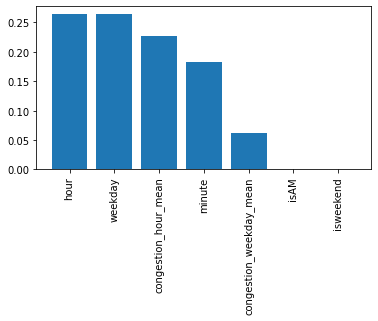

===========(2, 1, 'SB')===========


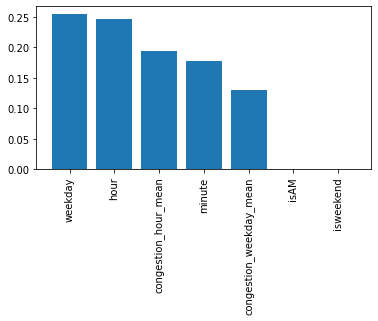

===========(2, 1, 'WB')===========


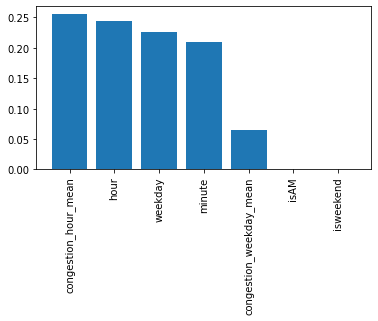

===========(2, 1, 'NE')===========


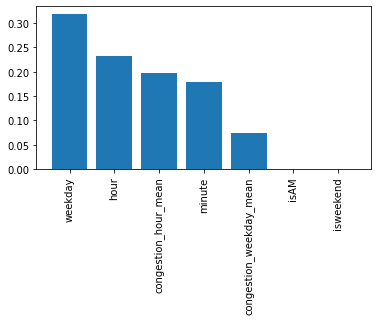

===========(2, 1, 'SW')===========


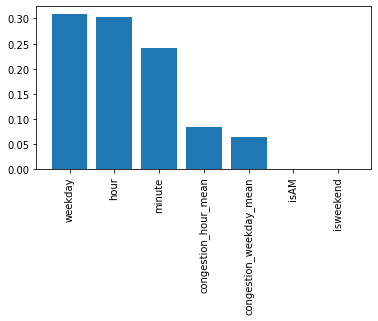

===========(2, 1, 'NW')===========


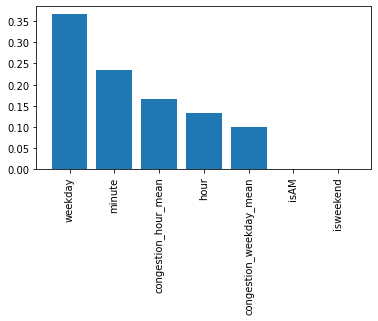

===========(2, 1, 'SE')===========


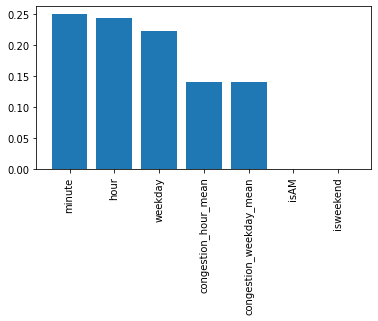

===========(2, 2, 'EB')===========


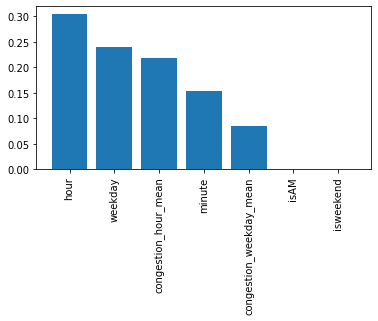

===========(2, 2, 'NB')===========


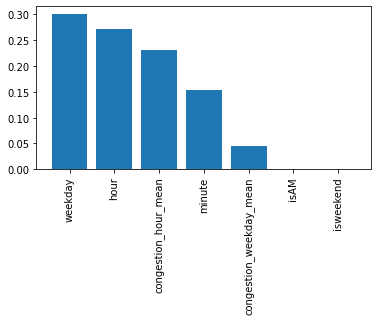

===========(2, 2, 'SB')===========


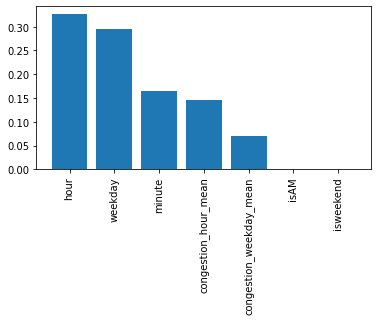

===========(2, 2, 'WB')===========


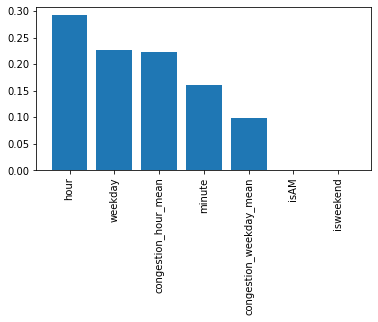

===========(2, 2, 'NE')===========


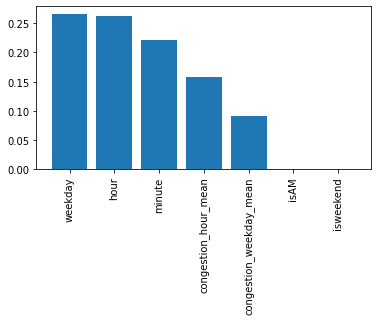

===========(2, 2, 'SW')===========


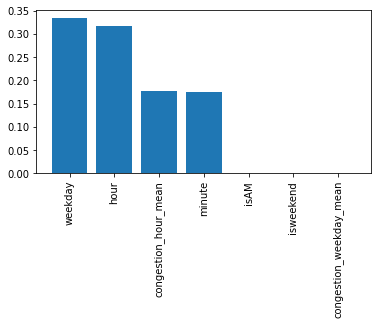

===========(2, 2, 'NW')===========


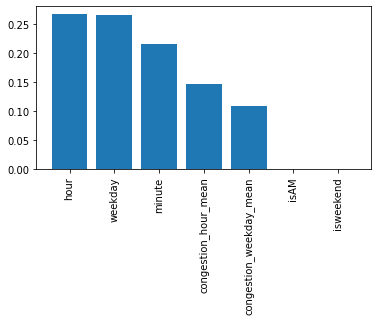

===========(2, 2, 'SE')===========


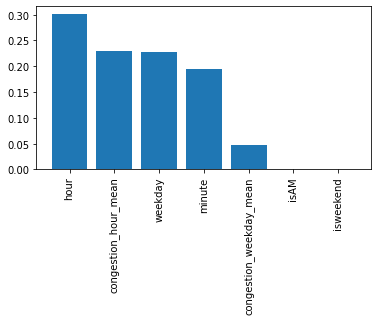

===========(2, 3, 'EB')===========


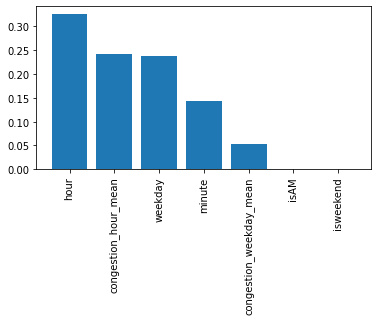

===========(2, 3, 'NB')===========


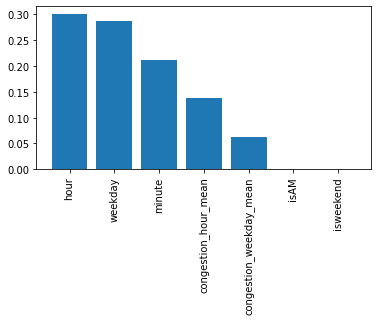

===========(2, 3, 'SB')===========


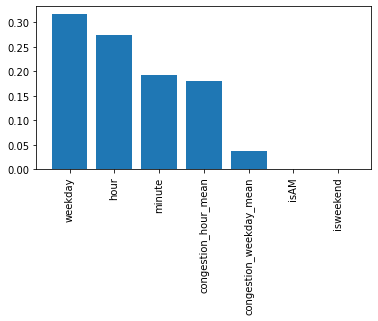

===========(2, 3, 'WB')===========


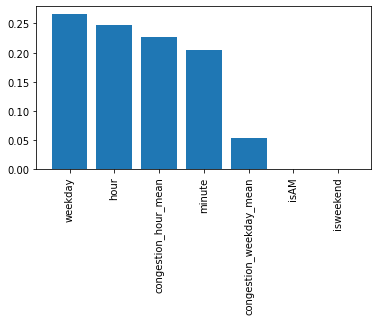

===========(2, 3, 'NE')===========


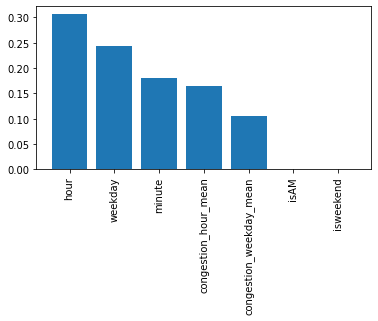

===========(2, 3, 'SW')===========


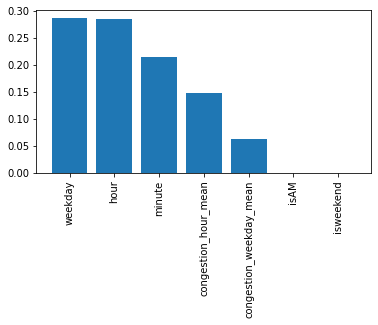

In [17]:
for key, models in all_models.items():
    f_importance = models[-1].feature_importance()
    f_importance = f_importance / sum(f_importance)
    df_importance = pd.DataFrame({"feature": feature_col, "importance": f_importance}).sort_values("importance", ascending=False)
    print("==========={}===========".format(key))
    plt.figure(figsize=(6, 3))
    plt.bar(x="feature", height="importance", data=df_importance)
    plt.xticks(rotation=90)
    plt.show()

### submit

In [18]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [19]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_009.csv -m "009"

100% 57.5k/57.5k [00:00<00:00, 262kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022